# Documentation

**Calculate Summer Anomalies from CMIP6 Data** 

**Spencer Ressel & Pedro Angulo Umaña**

April 4th, 2023

This notebook analyzes data from the Detection and Attribution Model Intercomparison Project (DAMIP): https://www.wcrp-climate.org/modelling-wgcm-mip-catalogue/cmip6-endorsed-mips-article/1062-modelling-cmip6-damip

Specifically, daily maximum temperature, outgoing longwave radiation (OLR), and sea surface temperatures (SST) are used to study the effects of climate change on heat waves over the Korean peninsula. This work is part of the CATER project.


# Imports

In [4]:
import os
from glob import glob

import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

# Specify models, experiments, and variables

In [2]:
models_list = ['ACCESS-ESM1-5', 'CanESM5', 'CNRM-CM6-1', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0']
# models_list = ['ACCESS-ESM1-5', 'CanESM5', 'MIROC6', 'MRI-ESM2-0']
experiments_list = ['historical', 'hist-nat', 'hist-GHG']

korean_peninsula = dict(lat=slice(34, 38), lon=slice(125, 130))
reference_period = dict(year=slice(1850,1950))

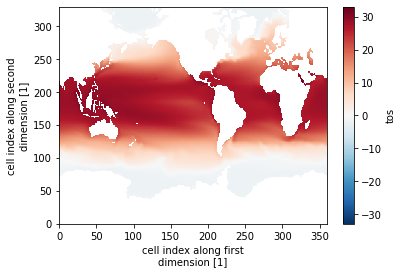

In [20]:
model = 'HadGEM3-GC31-LL'
exp = 'hist-nat'
variable = 'tos'
os.chdir('/home/disk/tc/pangulo/CMIP6/' + model)
# Load the data
file_name = sorted(glob('./' + exp + '/compiled_' + variable + '_*.nc'))[0]
[
    variable, 
    frequency, 
    model_name, 
    experiment, 
    variant, 
    grid, 
    period
] = file_name.split('/')[-1].split('.nc')[0].split('_')[1:]

temperature_data = xr.open_dataset(file_name)[variable]

temperature_data.mean(dim='time').plot()

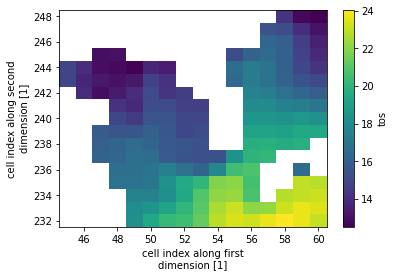

In [21]:
temperature_data

korea_west = 117.5
korea_east = 135
korea_south = 30
korea_north = 42.5
[korea_j, korea_i] = np.where(
    (temperature_data.latitude.values >= korea_south
    )*(temperature_data.latitude.values <= korea_north)
    *(temperature_data.longitude.values >= korea_west)
    *(temperature_data.longitude.values <= korea_east)
)
temperature_korea = temperature_data.isel(
    i=slice(korea_i.min(), korea_i.max()),
    j=slice(korea_j.min(), korea_j.max())
).mean(dim='time')

temperature_korea.plot()

# Do calculation

In [125]:
variable = 'tos'

from glob import glob
import xarray as xr
for model in models_list:
        for exp in experiments_list:
            # Set the directory
            os.chdir('/home/disk/tc/pangulo/CMIP6/' + model)
            
            # Load the data
            file_name = sorted(glob('./' + exp + '/compiled_' + variable + '_*.nc'))[0]
            [
                variable, 
                frequency, 
                model_name, 
                experiment, 
                variant, 
                grid, 
                period
            ] = file_name.split('/')[-1].split('.nc')[0].split('_')[1:]
            
            temperature_data = xr.open_dataset(file_name)[variable]
            
            if variable == 'tos':
                if model == 'IPSL-CM6A-LR':
                    j_lat = temperature_data.nav_lat[0].squeeze().data
                    i_lon = temperature_data.nav_lon[:,0].squeeze().data
                    temperature_data = temperature_data.rename({'nav_lon': 'lon', 'nav_lat': 'lat'}).assign_coords({'lon': i_lon, 'lat': j_lat}).sortby('lon')
                elif model == 'ACCESS-ESM1-5':
                    j_lat = temperature_data.latitude[:,0].squeeze().data
                    i_lon = temperature_data.longitude[0,:].squeeze().data
                    temperature_data = temperature_data.rename({'i': 'lon', 'j': 'lat'}).assign_coords({'lon': i_lon, 'lat': j_lat}).sortby('lon')
                elif model == 'CanESM5':
                    j_lat = temperature_data.latitude[:,0].squeeze().data
                    i_lon = temperature_data.longitude[0,:].squeeze().data
                    temperature_data = temperature_data.rename({'i': 'lon', 'j': 'lat'}).assign_coords({'lon': i_lon, 'lat': j_lat}).sortby('lon')
                elif model == 'MIROC6':
                    j_lat = temperature_data.latitude[:,0].squeeze().data
                    i_lon = temperature_data.longitude[0,:].squeeze().data
                    temperature_data = temperature_data.rename({'longitude': 'lon', 'latitude': 'lat'}).assign_coords({'lon': i_lon, 'lat': j_lat}).sortby('lon')
                
            # Subset the data to fit the Korean peninsula 
            daily_maximum_temperature_korea = temperature_data.sel(korean_peninsula).mean(dim=['lat', 'lon'])
            
            # Compute the mean summer temperature for each year
            summer_mean_max_temperature_by_year = daily_maximum_temperature_korea.sel(
                time=daily_maximum_temperature_korea['time.month'].isin([7,8])
            ).groupby('time.year').mean()
            
            # Compute the mean temperature of the reference period
            reference_period_mean_temperature = summer_mean_max_temperature_by_year.sel(reference_period).mean()
            
            # Compute anomalies from reference period
            summer_temperature_anomalies = summer_mean_max_temperature_by_year - reference_period_mean_temperature
            
            # Create new file to save temperature anomalies
            new_file_name = (
                variable
                + '_anomalies-' + str(reference_period['year'].start) + '-' + str(reference_period['year'].stop)
                + '_' + frequency 
                + '_' + model 
                + '_' + exp
                + '_' + variant 
                + '_' + grid
                + '_' + period
                + '.nc'
            )
            
            # Save output to netCDF
            print(new_file_name)
            summer_temperature_anomalies.to_netcdf('./' + exp + '/' + new_file_name)
            

ValueError: cannot add coordinates with new dimensions to a DataArray

In [89]:
new_file_name = (
    variable
    + '_anomalies-' + str(reference_period['year'].start) + '-' + str(reference_period['year'].stop)
    + '_' + frequency 
    + '_' + model 
    + '_' + exp
    + '_' + variant 
    + '_' + grid
    + '_' + period
    + '.nc'
)

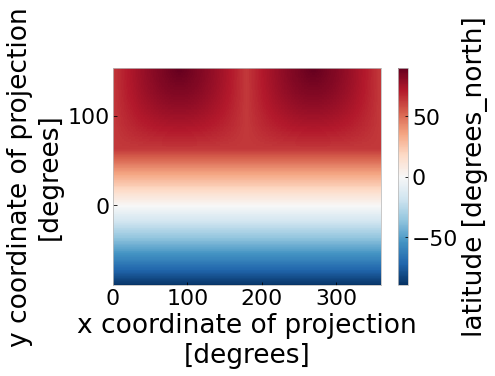

In [122]:
temperature_data.latitude.plot()

# Plot temperature anomalies

In [40]:
# models_list = ['ACCESS-ESM1-5']

plt.style.use('bmh')
plt.rcParams.update({'font.size':22})

for model in models_list:
    temperature_anomalies = {}
    for exp in experiments_list:
        # Set the directory
        os.chdir('/home/disk/tc/pangulo/CMIP6/' + model + '/' + exp)
        file_name = sorted(glob('tasmax_anomalies*.nc'))[0]
        [
            variable, 
            reference_period,
            frequency, 
            model_name, 
            experiment, 
            variant, 
            grid, 
            period
        ] = file_name.split('.nc')[0].split('_')
        temperature_anomalies[model + '_' + exp] = xr.open_dataset(file_name)['tasmax']

    [fig, ax] = plt.subplots(figsize=(16,9))
    ax.plot(
        temperature_anomalies[model + '_historical'].year, 
        temperature_anomalies[model + '_historical'],
        color='#348ABD',
        label='historical'
    )
    
    ax.plot(
        temperature_anomalies[model + '_hist-nat'].year, 
        temperature_anomalies[model + '_hist-nat'],
        color='#A60628',
        label='hist-nat'
    )
    
    ax.plot(
        temperature_anomalies[model + '_hist-GHG'].year, 
        temperature_anomalies[model + '_hist-GHG'],
        color='#7A68A6',
        label='hist-GHG'
    )
    ax.axhline(y=0, color='gray', alpha=0.5, ls='--')
    
    ax.legend(loc='upper left')
    ax.set_title(model + ', JA T-2m anomalies from ' + reference_period.split('-')[1] + '-' + reference_period.split('-')[2])
    ax.set_ylabel('°C')
    ax.set_xlabel('year')
    # ax.set_xlim(1950, 2022)
    # ax.set_aspect(50)
     
    # plt.show()
    
    os.chdir('/home/disk/tc/pangulo/CMIP6/' + model + '/')
    print(os.getcwd())
    picture_save_name = (
        'tasmax_anomalies-' 
        + str(reference_period.split('-')[1]) + '-' + str(reference_period.split('-')[2])
        + '_' + frequency 
        + '_' + model 
        + '.png'
    )
    
    plt.tight_layout(w_pad=5)
    plt.savefig(picture_save_name, dpi=400, format='png', bbox_inches='tight')
    plt.close()


/home/disk/tc/pangulo/CMIP6/ACCESS-ESM1-5
/home/disk/tc/pangulo/CMIP6/CanESM5
/home/disk/tc/pangulo/CMIP6/IPSL-CM6A-LR
/home/disk/tc/pangulo/CMIP6/MIROC6
/home/disk/tc/pangulo/CMIP6/MRI-ESM2-0


In [33]:
os.chdir('/home/disk/tc/pangulo/CMIP6/' + model + '/')
picture_save_name = (
    'tasmax_anomalies-' 
    + str(reference_period.split('-')[1]) + '-' + str(reference_period.split('-')[2])
    + '_' + frequency 
    + '_' + model 
    + '.png'
)
 
picture_save_name

'tasmax_anomalies-1850-1950_day_MRI-ESM2-0.png'